In [2]:
import pandas as pd
import numpy as np
import math
import logging
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from decimal import Decimal
from matplotlib.colors import BoundaryNorm

from statannotations.Annotator import Annotator

from scipy import stats
import statsmodels.stats.multitest
from decimal import Decimal

from sklearn import preprocessing

import pickle 
from matplotlib import rcParams

import warnings
warnings.filterwarnings('ignore')

import utils_statistics, utils_plotting, utils_misc

# 1. Data Loading

In [4]:
dystonia_genetics = pd.read_csv('dataset/genetic_dystonia_pallidal_neuron_activity.csv')
dystonia_genetics = dystonia_genetics[dystonia_genetics.patient!="patient1"] # removing benign-SGCE case

# fill np.nan values with 0
dystonia_genetics = dystonia_genetics.fillna(0)

genes             = ["AOPEP","GNAL","KMT2B","PANK2","PLA2G6","SGCE","THAP1","TOR1A","VPS16"]

features = dystonia_genetics.columns.to_list()
features.remove('patient')
features.remove('hemisphere')
features.remove('trajectory')
features.remove('depth')
features.remove('spike_pattern')
features.remove('gene')

features_non_param = features.copy()
features_non_param.remove('is_bursting')
features_non_param.remove('is_tonic')
features_non_param.remove('is_irregular')
features_non_param.remove('delta_band_oscillatory')
features_non_param.remove('theta_band_oscillatory')
features_non_param.remove('alpha_band_oscillatory')
features_non_param.remove('beta_band_oscillatory')
features_non_param.remove('gamma_band_oscillatory')
features_non_param.remove('is_oscillatory')

feat_binary = list(np.setdiff1d(features,features_non_param))

In [5]:
kw_results       = pd.read_csv("test_results/kruskall_wallis_test_results.csv")
mann_wu_results  = pd.read_csv("test_results/mann_whitney_u_results.csv")
chi2_results     = pd.read_csv("test_results/chi2_results.csv")
fisher_e_results = pd.read_csv("test_results/fisher_e_results.csv")

# 2. Plotting

In [7]:
def kw_section(axis, kw_results):           
    kw_results = kw_results[~np.isnan(list(kw_results.H))].sort_values(by=["cohens_d"], ascending=False).copy()
    kw_results.loc[kw_results.pvalue>0.05, 'cohens_d'] = 0
    axis       = sns.barplot(x="biomarker", y="cohens_d", data=kw_results, ax=axis)           
    plt.setp(axis.get_xticklabels(), rotation=90)
    axis.tick_params(axis='both', which='major', labelsize=labelsize)
    axis.tick_params(axis='both', which='minor', labelsize=labelsize)
    axis.set_xlabel('', fontsize=labelsize)
    axis.set_ylabel('', fontsize=labelsize)
    axis.set_title('$\mathregular{Cohens_d}$' + ' Effect Sizes of Kruskall-Wallis Test ', fontsize=labelsize+1, fontweight="bold")
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['bottom'].set_visible(False)
    axis.spines['left'].set_visible(False)
    axis.set_facecolor("white")

    for bar in axis.patches:
        if bar.get_height() < 0.5:
            bar.set_color('lightblue')    
        elif((bar.get_height() < 0.8) & (bar.get_height() >= 0.5)) :
            bar.set_color('teal') 
        else:
            bar.set_color('darkslategray')
            
    axis.tick_params('both', length=1, width=0.5, which='major')
    axis.tick_params('both', length=1, width=0.5, which='minor')
    return axis

def chi2_section(axis, results):           
    results     = results.sort_values(by=["cramers_v"], ascending=False).copy()
    results.loc[results.pvalue>0.05, 'cramers_v'] = 0
    axis        = sns.barplot(x="biomarker", y="cramers_v", data=results, ax=axis)           
    plt.setp(axis.get_xticklabels(), rotation=90)
    axis.tick_params(axis='both', which='major', labelsize=labelsize)
    axis.tick_params(axis='both', which='minor', labelsize=labelsize)
    axis.set_xlabel('', fontsize=labelsize)
    axis.set_ylabel('', fontsize=labelsize)
    axis.set_title('$\mathregular{Cramers_v}$' + ' Effect Sizes of Chi-Squared Test ', fontsize=labelsize+1, fontweight="bold")
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['bottom'].set_visible(False)
    axis.spines['left'].set_visible(False)
    axis.set_facecolor("white")
    axis.yaxis.tick_right()

    for bar in axis.patches:
        if bar.get_height() < 0.15:
            bar.set_color("#ffd1b3")    
        elif((bar.get_height() < 0.25) & (bar.get_height() >= 0.15)) :
            bar.set_color("#ff8533") 
        else:
            bar.set_color("#e64d00")
            
    axis.tick_params('both', length=1, width=0.5, which='major')
    axis.tick_params('both', length=1, width=0.5, which='minor')
    return axis

def mwu_section(dataset, gene_pair_order, features_order, axis):
    
    matrix  = pd.DataFrame(columns=dataset.biomarker.to_list())
    
    for index, row in dataset.iterrows():
        gene1     = row.gene1
        gene2     = row.gene2
        biomarker = row.biomarker
        odd_int   = row.cohens_d_interpretation
        pvalue    = row.pvalue
    
        if(pvalue<=0.05):
            if(odd_int=="large"):
                matrix.at[gene1+"-"+gene2, biomarker] = 0.8
            elif(odd_int=="medium"):
                matrix.at[gene1+"-"+gene2, biomarker] = 0.6
            else:
                matrix.at[gene1+"-"+gene2, biomarker] = 0.4
        else:
            matrix.at[gene1+"-"+gene2, biomarker] = 0.2
    
    
    bounds  = [0, 0.25, 0.5, 0.75, 1]
    heat_c  = ['white','lightblue', 'teal', 'darkslategray',]
    heat_n  = BoundaryNorm(bounds, ncolors=len(heat_c))
    val_min = 0
    val_max = 1
    
    matrix  = matrix.astype(float)
    matrix  = matrix[features_order]
    matrix  = matrix.loc[gene_pair_order]
    
    sns.heatmap(matrix, ax=axis, vmin=val_min, vmax=val_max, cmap=heat_c, rasterized=False,
                norm = heat_n , annot=False, cbar=False)
    axis.set_xticks([])
    axis.set_yticks([i+0.5 for i in range(len(matrix))])
    axis.set_yticklabels(matrix.index.to_list(), rotation=0)
    axis.tick_params(axis='both', which='major', labelsize=labelsize)
    axis.tick_params(axis='both', which='minor', labelsize=labelsize)
    axis.hlines(list(range(46)), *axis.get_xlim(), linewidth=0.5)

    small_patch  = mpatches.Patch(color='lightblue', label='Small')
    medium_patch = mpatches.Patch(color='teal', label='Medium')
    large_patch  = mpatches.Patch(color='darkslategray', label='Large')
    
    axis.tick_params('both', length=1, width=0.5, which='major')
    axis.tick_params('both', length=1, width=0.5, which='minor')
        
    return axis
    
def fisher_section(dataset, gene_pair_order, axis):

    dataset = dataset[dataset["test_type"] == "two-sided"]
    matrix  = pd.DataFrame(columns=dataset.biomarker.to_list())
    
    for index, row in dataset.iterrows():
        gene1     = row.gene1
        gene2     = row.gene2
        biomarker = row.biomarker
        odd_int   = row.odds_ratio_interpretation
        pvalue    = row.pvalue
    
        if(pvalue<=0.05):
            if(odd_int=="large"):
                matrix.at[gene1+"-"+gene2, biomarker] = 0.8
            elif(odd_int=="medium"):
                matrix.at[gene1+"-"+gene2, biomarker] = 0.6
            else:
                matrix.at[gene1+"-"+gene2, biomarker] = 0.4
        else:
            matrix.at[gene1+"-"+gene2, biomarker] = 0.2
    
    matrix  = matrix.astype(float)
    bounds  = [0, 0.25, 0.5, 0.75, 1]
    heat_c  = ['white','#ffd1b3', '#ff8533', '#e64d00',]
    heat_n  = BoundaryNorm(bounds, ncolors=len(heat_c))
    val_min = 0
    val_max = 1
    
    matrix = matrix.loc[:,~matrix.columns.duplicated()].copy()
    matrix = matrix[["is_tonic","beta_band_oscillatory","is_bursting","gamma_band_oscillatory","alpha_band_oscillatory","is_oscillatory","theta_band_oscillatory","is_irregular","delta_band_oscillatory"]]
    matrix = matrix.loc[gene_pair_order]
    
    sns.heatmap(matrix, ax=axis, vmin=val_min, vmax=val_max, cmap=heat_c, norm = heat_n , annot=False, annot_kws={"fontsize":16}, cbar=False)
    axis.set_xticks([])
    axis.tick_params(axis='both', which='major', labelsize=labelsize)
    axis.tick_params(axis='both', which='minor', labelsize=labelsize)
    axis.set_yticklabels([], rotation = 45, weight='bold')
    axis.hlines(list(range(46)), *axis.get_xlim(),  color='#ff8533', linewidth=0.5)
    
    small_patch  = mpatches.Patch(color='#ffd1b3', label='Small')
    medium_patch = mpatches.Patch(color='#ff8533', label='Medium')
    large_patch  = mpatches.Patch(color='#e64d00', label='Large')

    axis.tick_params(axis='both', which='major', labelsize=labelsize)
    axis.tick_params(axis='both', which='minor', labelsize=labelsize)
    
    return matrix


<Figure size 640x480 with 0 Axes>

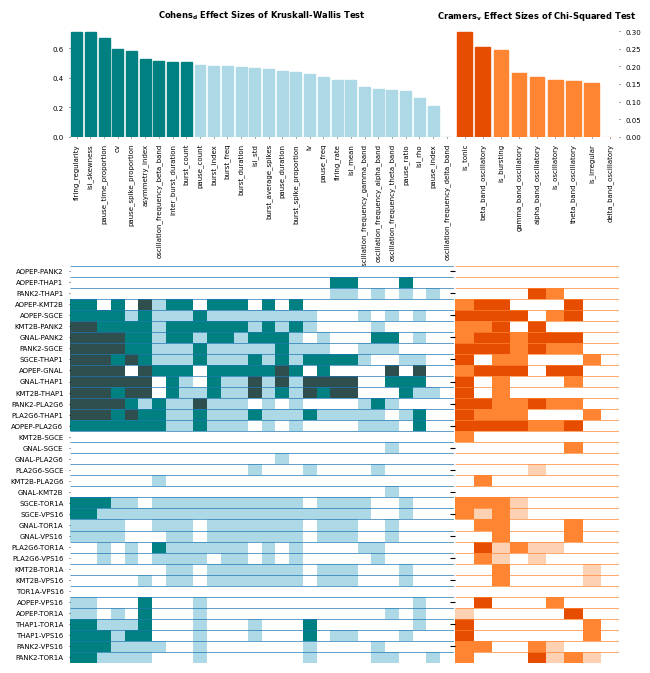

In [8]:
plt.rc('font', serif="Neue Haas Grotesk Text Pro")
labelsize=5

fig = plt.figure()
cm = 1/2.54  # centimeters in inches
plt.subplots(figsize=(18*cm, 21*cm))

ax_kw       = plt.subplot2grid((80, 50), (0, 0)  , colspan=35, rowspan=14)
ax_chi2     = plt.subplot2grid((80, 50), (0, 35) , colspan=15, rowspan=14)
ax_mwu      = plt.subplot2grid((80, 50), (30, 0) , colspan=35, rowspan=50)
ax_fisher   = plt.subplot2grid((80, 50), (30, 35), colspan=15, rowspan=50)


# order y-rows
feature_order = list(kw_results[~np.isnan(list(kw_results.H))].sort_values(by=["cohens_d"], ascending=False).biomarker)
desired_order = ['AOPEP-PANK2', 'AOPEP-THAP1', 'PANK2-THAP1', 'AOPEP-KMT2B', 'AOPEP-SGCE', 'KMT2B-PANK2', 'GNAL-PANK2', 'PANK2-SGCE', 
                 'SGCE-THAP1', 'AOPEP-GNAL','GNAL-THAP1', 'KMT2B-THAP1', 'PANK2-PLA2G6', 'PLA2G6-THAP1', 'AOPEP-PLA2G6', 'KMT2B-SGCE', 
                 'GNAL-SGCE', 'GNAL-PLA2G6', 'PLA2G6-SGCE', 'KMT2B-PLA2G6', 'GNAL-KMT2B', 'SGCE-TOR1A', 'SGCE-VPS16', 'GNAL-TOR1A', 
                 'GNAL-VPS16', 'PLA2G6-TOR1A', 'PLA2G6-VPS16', 'KMT2B-TOR1A', 'KMT2B-VPS16', 'TOR1A-VPS16',
                 'AOPEP-VPS16', 'AOPEP-TOR1A', 'THAP1-TOR1A', 'THAP1-VPS16', 'PANK2-VPS16','PANK2-TOR1A']

ax_kw       = kw_section(ax_kw, kw_results)
ax_chi2     = chi2_section(ax_chi2, chi2_results)
ax_mwu      = mwu_section(pd.DataFrame(mann_wu_results), gene_pair_order=desired_order, features_order=feature_order, axis=ax_mwu)
ax_fisher   = fisher_section(pd.DataFrame(fisher_e_results), desired_order, ax_fisher)
   
plt.savefig("figures/Figure 2.svg", dpi=300)
              